(guide/dataframe/selection)=

# Data Selection

As discussed in the {doc}`intro`, there are two key data structures in Meerkat: the Column and the DataFrame. In this guide, we'll demonstrate how to access the data stored within them.

Throughout, we'll be selecting data from the following DataFrame, which holds the Imagenette dataset, a small subset of the original ImageNet. This DataFrame includes a column holding images, a column holding their labels, and a few others.

In [1]:
import meerkat as mk
df = mk.get("imagenette", version="160px")

Below is an overview of the data selection methods discussed in this guide.

```{contents}
:local:
```

## Selecting Columns

The columns in a DataFrame are uniquely identified by `str` names. The code
below displays the column names in the Imagenette data frame we loaded above:

In [2]:
df.columns

['path',
 'noisy_labels_0',
 'noisy_labels_1',
 'noisy_labels_5',
 'noisy_labels_25',
 'noisy_labels_50',
 'is_valid',
 'label_id',
 'label',
 'label_idx',
 'split',
 'img_path',
 'img_id',
 'index',
 'img']

Using these column names, we can pull out an individual column or a subset of them as a new DataFrame.

### Selecting a Single Column

#### `str` -> {class}`~meerkat.Column`

To select a single column, we simply pass it's name to the index operator. For example,

,(FileColumn)
0,
1,
2,
3,
4,

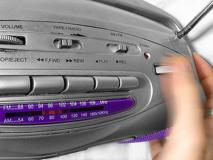
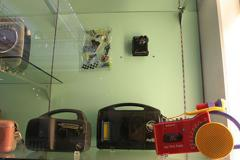
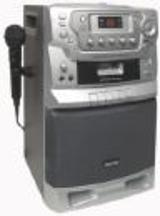
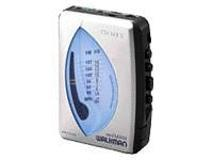
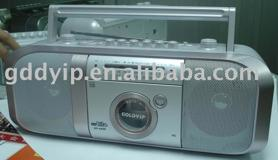

In [3]:
   col = df["img"]
   col.head()

Passing a `str` that isn't among the column names will raise a `KeyError`.

It may be helpful to think of a DataFrame as a dictionary mapping column names to columns.

Indeed, a DataFrame implements other parts of the `dict` interface including :meth:`~meerkat.DataFrame.keys()`, :meth:`~meerkat.DataFrame.values()`, and :meth:`~meerkat.DataFrame.items()`. Unlike a dictionary, multiple columns in a DataFrame can be selected at once.

### Selecting Multiple Columns

#### `List[str]` -> {class}`~meerkat.DataFrame`

You can select multiple columns by passing a list of column names. Doing so will return a new DataFrame with a subset of the columns in the original. For example,

In [4]:
    df = df[["img", "img_id", "label"]]
    df.head()

Frontend is not initialized. Running `mk.gui.start()`.

Passing a `str` that isn't among the column names will raise a `KeyError`.

```{admonition} Copy vs. Reference
See {doc}`copying` for more information.

You may be wondering whether the columns returned by indexing are copies of the columns in the original DataFrame. The columns returned by the index operator reference the same columns in the original DataFrame. This means that modifying the columns returned by the index operator will modify the columns in the original DataFrame.
```

## Selecting Rows by Position

In Meerkat, the rows of a DataFrame or Column are ordered. This means that rows are uniquely identified by their position in the DataFrame or Column (similar to how the elements of a [Python List](https://www.w3schools.com/python/python_lists.asp) are uniquely identified by their position in the list).

Row indices range from 0 to the number of rows in the DataFrame or Column minus one. To see how many rows a DataFrame or a column has we can use `len()`. For example,

In [5]:
   len(df)

13394

Above we mentioned how a DataFrame could be viewed as a dictionary mapping column names to columns. Equivalently, it also may be helpful to think of a DataFrame as a list of dictionaries mapping column names to values. The DataFrame interface supports both of these views – under the hood, storage is organized so as to make both column and row accesses fast.

### Selecting a Single Row by Position

#### `int` -> {class}`~meerkat.Row`

To select a single row from a DataFrame, we simply pass it's position to the index operator.

In [6]:
   row = df[2]
   row

{'img': FileCell(fn=<meerkat.columns.deferred.file.FileLoader object at 0x7f11899634f0>),
 'img_id': 'n02979186_9715',
 'label': 'cassette player'}

Passing an `int` that is less than `0` or greater than `len(df)` will raise an `IndexError`.

Notice that `row` holds a {class}`~meerkat.FileCell` object, not a [PIL Image](https://pillow.readthedocs.io/en/stable/reference/Image.html) or other in-memory image object.
The "image" has not yet been loaded from disk into memory. The {class}`~meerkat.FileCell` knows how to load the image into memory, but stops just short of doing so.
Later on, when we want to access the image, we can _call_ the row or cell to load the image into memory.

In [7]:
   row()

{'img': <PIL.Image.Image image mode=RGB size=160x216>,
 'img_id': 'n02979186_9715',
 'label': 'cassette player'}

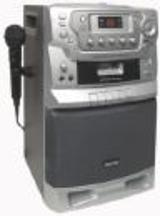

In [8]:
   row["img"]()

_Why do we wait to load the image into memory?_ Image datasets often don't fit into memory. By deferring the loading of images until they are needed, we can manipulate large image datasets quickly.

```{admonition} Materializing Deferred Columns
The images in `df` are stored in a subclass of {class}`~meerkat.DeferredColumn` called {class}`~meerkat.ImageColumn`.
Deferred columns are a special type of column that defer the materialization of data until it is needed. They play a central role in Meerkat as they make it easy to work with large data types like images and videos.
Learn more in the {doc}`deferred` guide.
```

#### `int` -> {class}`Any`

The same position-based indexing works for selecting a single cell from a Column.

In [9]:
col = df["label"]
col[2]

'cassette player'

Passing an `int` that is less than `0` or greater than `len(df["label"])` will raise an `IndexError`.

### Selecting Multiple Rows by Position

There are three different ways we can select a subset of rows from a DataFrame or Column: via `slice`, `Sequence[int]`, or `Sequence[bool]`.

#### `slice` -> {class}`~meerkat.DataFrame`

To select a set of contiguous rows from a DataFrame, we can use an integer slice `[start:end]`.
The subset of rows will be returned as a new DataFrame.

In [10]:
    df[50:100]

We can also use integer slices to select a set of evenly spaced rows from a DataFrame `[start:end:step]`. For example, below we select every tenth row from the first 100 rows in the DataFrame.

In [11]:
    df[0:100:10]

#### `Sequence[int]` -> {class}`~meerkat.DataFrame`

To select multiple rows from a DataFrame we can also pass a list of `int`.

In [12]:
    small_df = df[[0, 2, 5, 8, 17]]
    small_df

Other valid sequences of `int` that can be used to index are:

- `Tuple[int]` – a tuple of integers.
- `np.ndarray[np.integer]` - a NumPy NDArray with `dtype` `np.integer`.
- `pd.Series[np.integer]` - a Pandas Series with `dtype` `np.integer`.
- `torch.Tensor[torch.int64]` - a PyTorch Tensor with `dtype` `torch.int`.
- `mk.Column` - a Meerkat column who's cells are `int`, `np.integer`, or `torch.int64`.

This is useful when the rows are neither contiguous nor evenly spaced (otherwise slice indexing, described above, is faster).

#### `Sequence[bool]` -> {class}`~meerkat.DataFrame`

To select multiple rows from a DataFrame we can also pass a list of `bool` the
same length as the DataFrame. Below we select the first and last rows from
the smaller DataFrame `small_df` that we selected in the panel above.

In [13]:
small_df[[True, False, False, False, True]]

Other valid sequences of `bool` that can be used to select are:

- `Tuple[bool]` – a tuple of bool.
- `np.ndarray[bool]` - a NumPy NDArray with `dtype` `bool`.
- `pd.Series[bool]` - a Pandas Series with `dtype` `bool`.
- `torch.Tensor[torch.bool]` - a PyTorch Tensor with `dtype` `torch.bool`.
- `mk.Column` - a Meerkat column who's cells are `int`, `bool`, or `torch.bool`.

This is very useful for quickly selecting a subset of rows that satisfy a predicate
(like you might do with a `WHERE` clause in SQL).
For example, say we want to select all rows that have a value of `"parachute"` in
the `"label"` column. We could do this using the following code:

In [14]:
    parachute_df = df[df["label"] == "parachute"]
    parachute_df.head()

```{admonition} Copy vs. Reference

See {doc}`advanced/copying.rst` for more information.

You may be wondering whether the rows returned by indexing are copies or references of the rows in the original DataFrame.
This depends on (1) which of the selection strategies above you use (``slice`` vs. ``Sequence[int]`` vs. ``Sequence[bool]``)  and (2) the column type (*e.g.* {class}`PandasSeriesColumn`, {class}`TensorColumn`).

In general, columns inherit the copying behavior of their underlying data structure.
For example, a {class}`TensorColumn` has the copying behavior of a NumPy array, as described in the `Numpy indexing documentation <https://numpy.org/doc/stable/reference/arrays.indexing.html>`_.
See a more detailed discussion in {doc}`advanced/copying.rst` .
```

(key-based-selection)=

## Selecting Rows by Key

It is also possible to select rows from a DataFrame by a key column.
In Meerkat, a key column is a {class}`~meerkat.ScalarColumn` containing `str` or `int` values that uniquely identify each row. The primary key in Meerkat is analogous to the primary key in a SQL database or the index in a Pandas DataFrame.

The primary key of `df` is the `"img_id"` column.

In [15]:
    print(df.primary_key_name)
    df.primary_key

img_id


,(PandasScalarColumn)
0,n02979186_9036
1,n02979186_11957
2,n02979186_9715
3,n02979186_21736
4,ILSVRC2012_val_00046953
...,...
13389,n03425413_17521
13390,n03425413_20711
13391,n03425413_19050
13392,n03425413_13831


The primary key can be set using {func}`~meerkat.DataFrame.set_primary_key`, which takes a column name or a {class}`~meerkat.ScalarColumn` as input.

### Selecting a Single Row by Key

#### `str|int` -> {class}`~meerkat.Row`

To select a single row from a DataFrame by key, we can use the `.loc[]` operator and pass a key value.

In [16]:
    df.loc["n03888257_37776"]

{'img': FileCell(fn=<meerkat.columns.deferred.file.FileLoader object at 0x7f11899634f0>),
 'img_id': 'n03888257_37776',
 'label': 'parachute'}

### Selecting Multiple Rows by Key

#### `Sequence[str|int]` -> {class}`~meerkat.DataFrame`

We can also select a subset of rows in a DataFrame by passing a list of key values to `.loc[]`.

In [17]:
    df.loc[["n03888257_37776", "n03425413_20711", "n03425413_1242"]]

Passing a `str|int` that isn't in the primary key will raise a `KeyError`.

```{admonition} For Pandas Users

``index vs. primary key``:
Pandas DataFrames maintain an index object that is separate from the DataFrame's columns.
The index object is used to select rows by key using the ``.loc[]`` indexer.
In Meerkat, there is no separate index object.
Instead, we designate one of the columns the primary key and can select rows based on the values in that column using ``.loc[]``.
The Meerkat approach, where the primary key is a column in the DataFrame, resembles the approach taken by most SQL databases.

``.iloc``:
Pandas users are likely familiar with ``.loc`` properties of DataFrame and Series.
These properties are used to select data by integer position and by key in the index, respectively.
In Meerkat, we do not support ``.iloc`` – to index by position, simply apply the index operator `[]` directly to the object.
```